In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")    
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [15]:
def plot_verification(df):
    PAGESIZE = 4096
    compact_ios = (df['compact_read'] + df['compact_write']) / PAGESIZE
    df['write_ios'] = ((df['bytes_written'] + df['flush_written']) / PAGESIZE) + compact_ios
#     df['write_ios'] = 0
    df['total_ios'] = df['blocks_read'] + df['write_ios']
    df['io_per_query'] = df['total_ios'] / 100000
    df['model_io_per_query'] = df['model_io'] / 100000
    
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    ax.plot(df['N'], df['io_per_query'],       marker='o', color='blue', label='System')
    ax2.plot(df['N'], df['model_io_per_query'],marker='*', color='black', label='Model')
    ax.set_xscale('log')
    ax.set_ylabel('System I/Os per Query', color='blue')
    ax.set_xlabel('Number of Elements in DB (N)')
    ax2.set_ylabel('Model I/Os per Query', color='black')
    ax.tick_params(axis='y', colors='blue')
    ax.set_title('Verification of Database Size')
    plt.show()

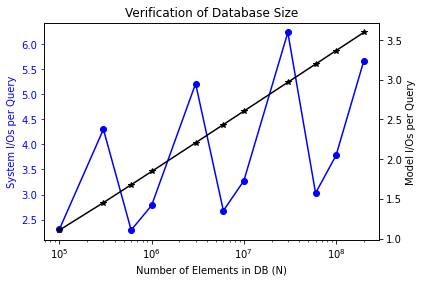

In [16]:
df = dp.read_csv('exp_04_leveling.csv')
plot_verification(df)

In [6]:
df

N  phi    s  B     E             M  is_leveling_policy  T   h  \
0      100000.0    1  0.0  4  8192  6.810886e+07                True  8  10   
1      300000.0    1  0.0  4  8192  7.010886e+07                True  8  10   
2      600000.0    1  0.0  4  8192  7.310886e+07                True  8  10   
3     1000000.0    1  0.0  4  8192  7.710886e+07                True  8  10   
4     3000000.0    1  0.0  4  8192  9.710886e+07                True  8  10   
5     6000000.0    1  0.0  4  8192  1.271089e+08                True  8  10   
6    10000000.0    1  0.0  4  8192  1.671089e+08                True  8  10   
7    30000000.0    1  0.0  4  8192  3.671089e+08                True  8  10   
8    60000000.0    1  0.0  4  8192  6.671089e+08                True  8  10   
9   100000000.0    1  0.0  4  8192  1.067109e+09                True  8  10   
10  200000000.0    1  0.0  4  8192  2.067109e+09                True  8  10   

    l0_hit  ...  compact_read  compact_write  flush_written  blocks_read  \
0     2793  ...     242555858      241092608       26070878       100002   
1     2749  ...     651712726      648045056       26070366        99921   
2      428  ...     189336464      187708928       26083678       124326   
3      358  ...     291087531      288887296       26084702       124102   
4      464  ...     793051761      788119040       26084714       122174   
5       75  ...     227520893      225443840       26098026       144509   
6       87  ...     355199224      351893504       26098026       141979   
7      206  ...     977226403      970579968       26098026       134736   
8       68  ...     275897927      273176576       26111338       156143   
9       64  ...     433299740      430665216       26111338       154215   
10     145  ...     823189533      818535936       26111338       152625   

                                      runs_per_level       model_io  \
0   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  110634.235599   
1   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  145243.801126   
2   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  167726.200470   
3   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  184436.384504   
4   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  220578.860821   
5   [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  243451.541468   
6   [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  260322.299905   
7   [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  296626.310938   
8   [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  319538.598048   
9   [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  336425.587498   
10  [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  359340.900039   

        write_ios      total_ios  io_per_query  model_io_per_query  
0   130790.855469  230792.855469      2.307929            1.106342  
1   330036.168945  429957.168945      4.299572            1.452438  
2   104767.839355  229093.839355      2.290938            1.677262  
3   154311.408447  278413.408447      2.784134            1.844364  
4   398744.022217  520918.022217      5.209180            2.205789  
5   123306.337646  267815.337646      2.678153            2.434515  
6   185349.305176  327328.305176      3.273283            2.603223  
7   488257.909424  622993.909424      6.229939            2.966263  
8   146773.886963  302916.886963      3.029169            3.195386  
9   223651.438965  377866.438965      3.778664            3.364256  
10  413534.376709  566159.376709      5.661594            3.593409  

[11 rows x 30 columns]